In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import random

In [6]:
df = pd.read_csv('cleaned_hospital.csv')

grouped_df = df.groupby(['Year', 'APR DRG Code']).agg({
    'Discharges': 'sum',
    'Median Charge': 'median',
    'Median Cost': 'median'
}).reset_index()

# print(df['Year'].unique())
# print(sorted(df['Year'].unique()))

# grouped_df['Prev_Year_Discharges'] = grouped_df.groupby('APR DRG Code')['Discharges'].shift(1)
# grouped_df = grouped_df.dropna(subset=['Prev_Year_Discharges'])

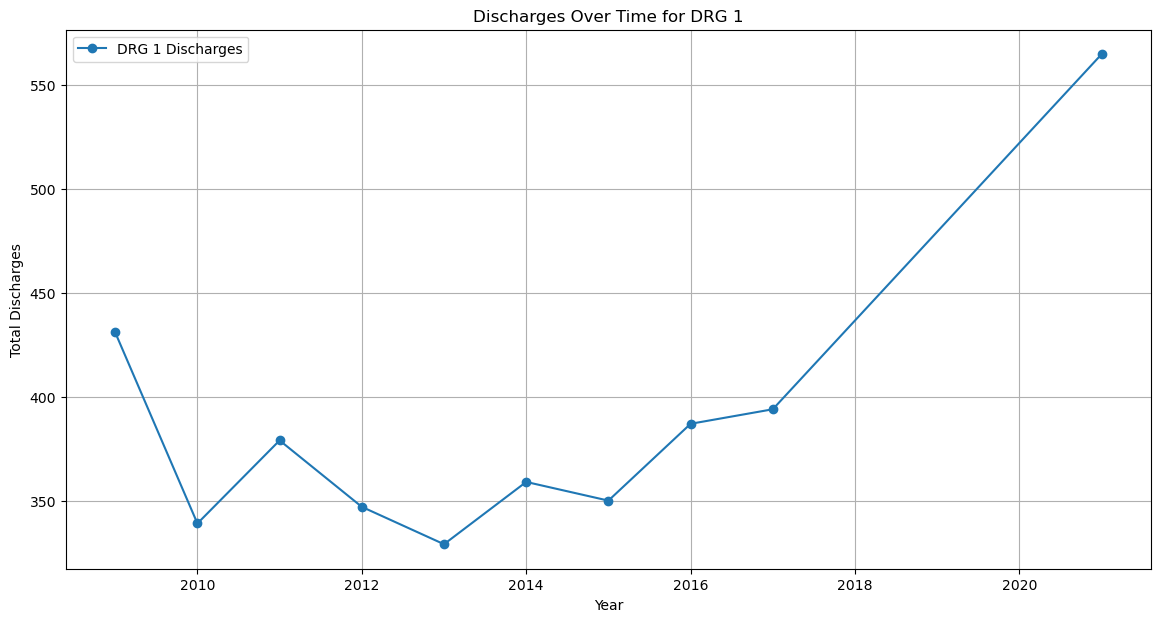

In [7]:
# Plotting charge to a DRG over time
selected_drg = 1
drg_data = df[df['APR DRG Code'] == selected_drg]

yearly_drg_data = drg_data.groupby('Year')['Discharges'].sum()

plt.figure(figsize=(14, 7))
plt.plot(yearly_drg_data.index, yearly_drg_data.values, marker='o', label=f'DRG {selected_drg} Discharges')
plt.title(f'Discharges Over Time for DRG {selected_drg}')
plt.xlabel('Year')
plt.ylabel('Total Discharges')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
train_ratio = 0.8
actual_vs_predicted = {}

for drg in grouped_df['APR DRG Code'].unique():
    drg_data = grouped_df[grouped_df['APR DRG Code'] == drg].sort_values('Year')

    n_years = drg_data['Year'].nunique()

    if n_years >= 5:
        years = grouped_df['Year'].unique()
        years = list(years)

        random.shuffle(years)
        split_idx = int(len(years) * 0.8)

        train_years = years[:split_idx]
        test_years = years[split_idx:]

        train_data = drg_data[drg_data['Year'].isin(train_years)]
        test_data = drg_data[drg_data['Year'].isin(test_years)]

        if not test_data.empty:
            # feature_cols = ['Year', 'Median Charge', 'Median Cost', 'Prev_Year_Discharges']
            feature_cols = ['Year', 'Median Charge', 'Median Cost']
            X_train = train_data[feature_cols]
            y_train = train_data['Discharges']

            X_test = test_data[feature_cols]
            y_test_actual = test_data['Discharges']

            try:
                model = RandomForestRegressor(n_estimators=500, max_depth=6, random_state=42)
                model.fit(X_train, y_train)

                y_pred = model.predict(X_test)

                for true_val, pred_val in zip(y_test_actual, y_pred):
                    actual_vs_predicted[(drg, true_val)] = pred_val

                print(f"Training for DRG {drg}")

            except Exception as e:
                print(f"Failed for DRG {drg}: {e}")
    else:
        print(f"Not enough data for DRG {drg}")


Training for DRG 1
Training for DRG 2
Training for DRG 3
Training for DRG 4
Training for DRG 5
Training for DRG 6
Training for DRG 20
Training for DRG 21
Training for DRG 22
Training for DRG 23
Training for DRG 24
Training for DRG 26
Training for DRG 40
Training for DRG 41
Training for DRG 42
Training for DRG 43
Training for DRG 44
Training for DRG 45
Training for DRG 46
Training for DRG 47
Training for DRG 48
Training for DRG 49
Training for DRG 50
Training for DRG 51
Training for DRG 52
Training for DRG 53
Training for DRG 54
Training for DRG 55
Training for DRG 56
Training for DRG 57
Training for DRG 58
Training for DRG 70
Training for DRG 73
Training for DRG 80
Training for DRG 82
Training for DRG 89
Training for DRG 90
Training for DRG 91
Training for DRG 92
Training for DRG 93
Training for DRG 95
Training for DRG 97
Training for DRG 98
Training for DRG 110
Training for DRG 111
Training for DRG 113
Training for DRG 114
Training for DRG 115
Training for DRG 120
Training for DRG 121

<Figure size 1400x600 with 0 Axes>

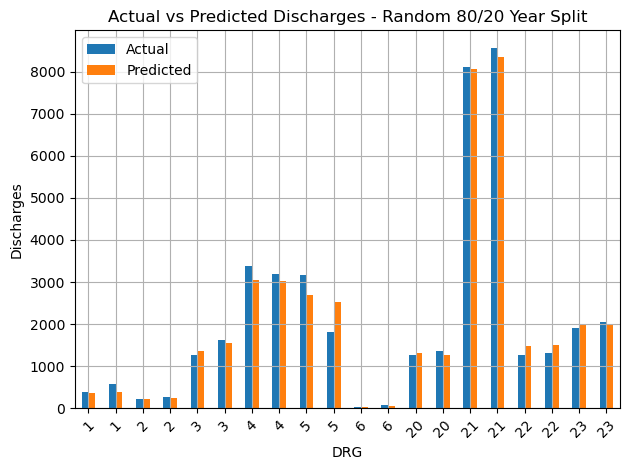

In [9]:
# Plotting

results_df = pd.DataFrame([
    {"DRG": drg, "Actual": actual, "Predicted": predicted}
    for (drg, actual), predicted in actual_vs_predicted.items()
])

results_df['Actual'] = pd.to_numeric(results_df['Actual'], errors='coerce')
results_df['Predicted'] = pd.to_numeric(results_df['Predicted'], errors='coerce')
results_df = results_df.dropna()

if not results_df.empty:
    plt.figure(figsize=(14, 6))
    subset = results_df.head(20)  # Take top 20 rows
    subset.plot(x='DRG', y=['Actual', 'Predicted'], kind='bar')
    plt.title('Actual vs Predicted Discharges - Random 80/20 Year Split')
    plt.xlabel('DRG')
    plt.ylabel('Discharges')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No results to plot.")


In [10]:
actual = results_df['Actual']
predicted = results_df['Predicted']

mse = mean_squared_error(actual, predicted)
rmse = mse ** 0.5
r2 = r2_score(actual, predicted)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

MSE: 2380839.86
RMSE: 1543.00
R² Score: 0.9919


In [11]:
results_df.head()

,DRG,Actual,Predicted
0,1,379.0,356.056
1,1,565.0,382.748
2,2,230.0,226.348
3,2,265.0,251.392
4,3,1272.0,1352.146


## Fairness Considerations 

**Why fairness matters:**  
This model predicts total expected discharges by DRG Type for NY hospitals. Fairness ensures equitable resource allocation across facilities, treatment types, and severity levels to prevent systemic biases that could harm underserved populations or compromise care quality.

**2 Key Fairness Questions:**
1. Are predictions equally reliable for both common and rare DRG types?  
2. Does accuracy remain stable across all severity-of-illness levels?  

### Question 1:
**Fairness Criteria:**
The predictive model should demonstrate consistent error rates across different DRG types.

/var/folders/vs/cp4_j_996rz55hth8zrbfrgw0000gn/T/ipykernel_90177/2443603489.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  drg_errors = results_df.groupby('DRG').apply(


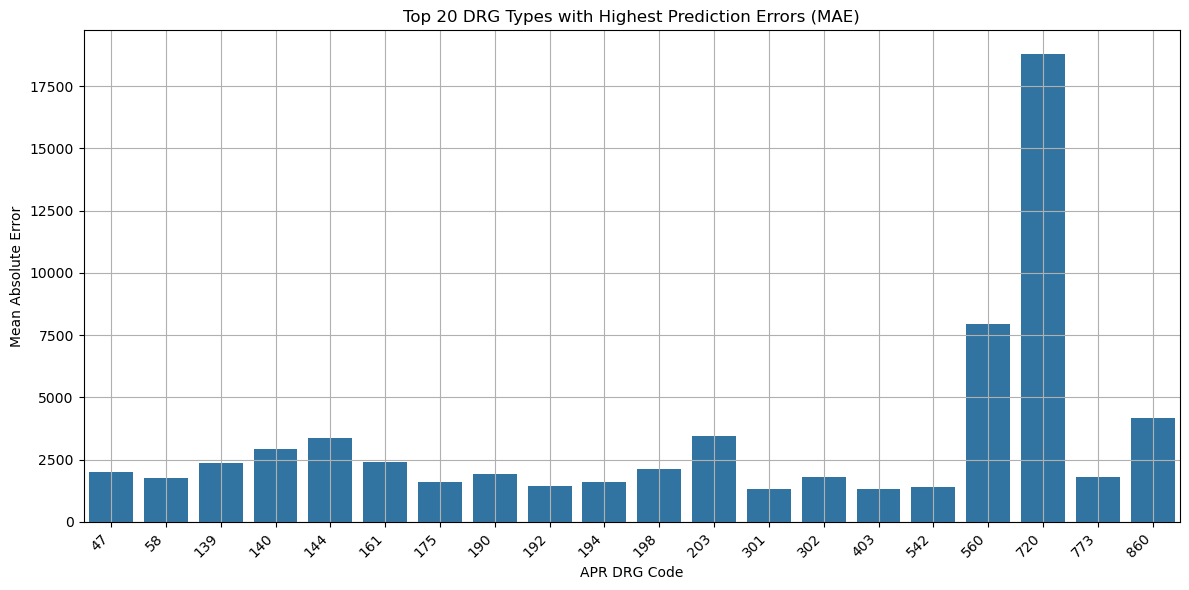

In [21]:
# Calculate MAE for each DRG
drg_errors = results_df.groupby('DRG').apply(
    lambda x: mean_absolute_error(x['Actual'], x['Predicted'])
).reset_index(name='MAE')

# Step 2: Visualize Top-20 DRG by MAE
top_n = 20
top_drg_errors = drg_errors.sort_values('MAE', ascending=False).head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x='DRG', y='MAE', data=top_drg_errors)
plt.title(f'Top {top_n} DRG Types with Highest Prediction Errors (MAE)')
plt.xlabel('APR DRG Code')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()



We decided to explore the top 20 DRGs with the highest Mean Absolute Error (MAE).

From the graph above, we noticed that Septicemia (APR DRG Code = 720) and Aftercare, Musculoskeletal System and Connective Tissue with CC (APR DRG Code = 560) have exceptionally high prediction errors compared to other DRG types.

In [19]:
high_error_drgs = [720, 560]

for drg in high_error_drgs:
    count = results_df[results_df['DRG'] == drg].shape[0]
    print(f"DRG {drg} has {count} records.")

DRG 720 has 2 records.
DRG 560 has 2 records.


We checked the number of records of this two DRG and both of them only had 2 records. This observation reminds us to check the model performance on rare DRGs (DRGs with fewer than 2 records).

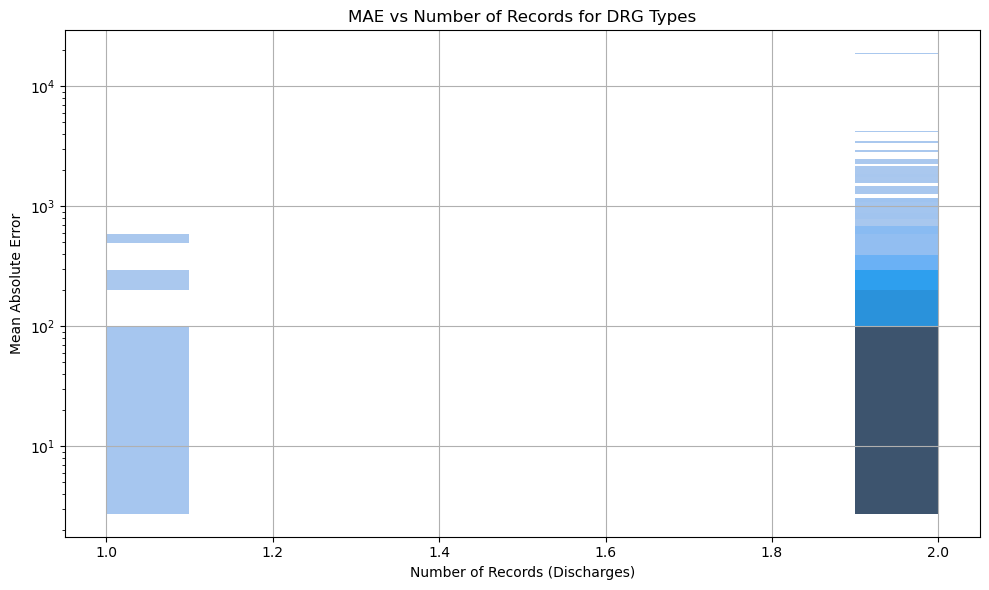

In [30]:
drg_volume = results_df.groupby('DRG').size().reset_index(name='Num_Records')

drg_analysis = drg_errors.merge(drg_volume, on='DRG')

plt.figure(figsize=(10,6))
sns.histplot(x='Num_Records', y='MAE', data=drg_analysis)
plt.title('MAE vs Number of Records for DRG Types')
plt.yscale('log')
plt.xlabel('Number of Records (Discharges)')
plt.ylabel('Mean Absolute Error')
plt.grid(True)
plt.tight_layout()
plt.show()

From the graph above: 
- We noticed that our model has poor performance in predicting discharges for rare DRG types.
- Users are advised not to rely on the model’s current predictions for rare DRGs.

Future work: 
- Prioritize the collection of more training data for rare DRGs.
- Develop separate models for common vs. rare DRGs.

### Question 2

**Fairness Criteria:**
The predictive model should demonstrate consistent error rates across different severity of illness levels.


Steps: 
- Merged severity into the model prediction results
- Grouped results by severity level and calculated the Mean Absolute Error (MAE) for each group.
- Visualized the MAE across different severity levels.

/var/folders/vs/cp4_j_996rz55hth8zrbfrgw0000gn/T/ipykernel_90177/2402690924.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  severity_errors = results_with_severity.groupby('APR Severity of Illness Code').apply(


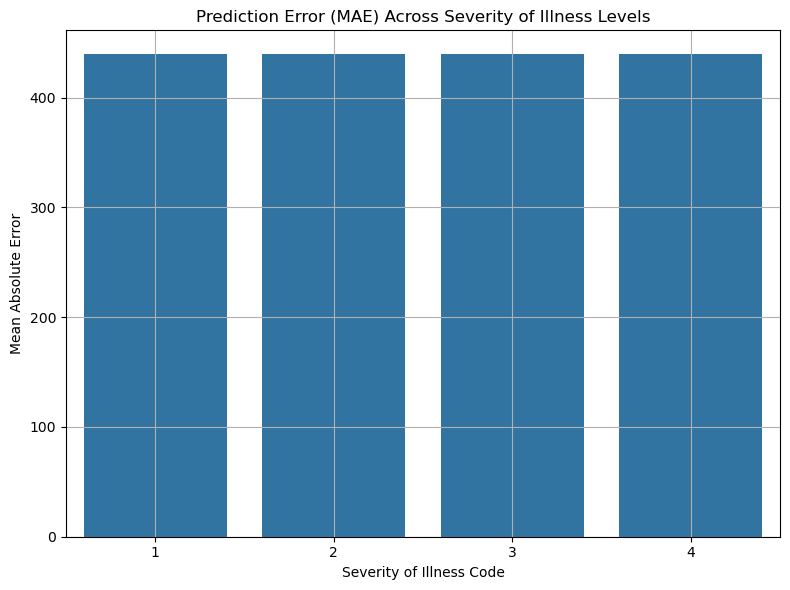

In [27]:
severity_info = df[['APR DRG Code', 'APR Severity of Illness Code']].drop_duplicates()

results_with_severity = results_df.merge(
    severity_info,
    left_on='DRG',
    right_on='APR DRG Code',
    how='left'
)

severity_errors = results_with_severity.groupby('APR Severity of Illness Code').apply(
    lambda x: mean_absolute_error(x['Actual'], x['Predicted'])
).reset_index(name='MAE')

plt.figure(figsize=(8,6))
sns.barplot(x='APR Severity of Illness Code', y='MAE', data=severity_errors)
plt.title('Prediction Error (MAE) Across Severity of Illness Levels')
plt.xlabel('Severity of Illness Code')
plt.ylabel('Mean Absolute Error')
plt.grid(True)
plt.tight_layout()
plt.show()

Based on the graph above, our model demonstrates consistent prediction errors across different severity levels. Thus, the model is fair with respect to severity level.


### Additional Concerns

We also aimed to explore whether our model exhibited potential discrimination against hospitals in specific geographic locations (e.g., based on zipcode information).

However, due to the lack of time, we have deferred this analysis to future work.

**Additional zipcode dataset**, which can be joined with Facility Id, is available at: https://health.data.ny.gov/Health/Health-Facility-General-Information/vn5v-hh5r/about_data